# LLF_tidy_images - Extended Recruitment Experiment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from proglearn.forest import LifelongClassificationForest
from sklearn.model_selection import train_test_split

In [3]:
from matplotlib.ticker import ScalarFormatter

from proglearn.progressive_learner import ClassificationProgressiveLearner
from proglearn.transformers import TreeClassificationTransformer
from proglearn.voters import TreeClassificationVoter
from proglearn.deciders import SimpleArgmaxAverage

## FTE/BTE Experiment

### Preprocess Data

#### Helper Functions

In [4]:
def shift_data(x, y, shift):
    """
    """
    
    # shift x labels
    x_shifted = x[shift:] + x[:shift]
    y_shifted = y[shift:] + y[:shift]
    
    # modify labels based on shift
    new_y = []
    for idx, lbl_set in enumerate(y_shifted):
        if idx == 0:
            new_y.append(y_shifted[idx])
        else:
            counter = 0
            for i in range(idx):
                counter += len(np.unique(y_shifted[i]))
            new_y.append(y_shifted[idx] + counter)
    y_shifted = new_y
    
    return x_shifted, y_shifted

In [5]:
def check_normalize(imgs, norm_indicator):
    """
    """
    
    # no normalization
    if norm_indicator==False:
        return imgs
    
    # normalization per image
    elif norm_indicator=="image":
        for img in imgs:
            # normalize each channel in each image
            for channel in range(3):
                channel_max = np.amax(img[:,:,channel])
                channel_min = np.amin(img[:,:,channel])
                img[:,:,channel] = 255 * ((img[:,:,channel]-channel_min) / (channel_max-channel_min))
        # check that all images are on scale of 0-255
        for idx, img in enumerate(imgs):
            maxes = np.array([np.amax(img[:,:,0]), np.amax(img[:,:,1]), np.amax(img[:,:,2])])
            mins = np.array([np.amin(img[:,:,0]), np.amin(img[:,:,1]), np.amin(img[:,:,2])])
            if np.logical_and(maxes != np.array([255,255,255]), mins != np.array([0,0,0])).any():
                print("CAUTION: error in normalization of image %d." % idx)
        return imgs
    
    # normalization per dataset
    elif norm_indicator=="dataset":
        # normalize each channel over dataset
        for channel in range(3):
            channel_max = np.amax(imgs[:,:,:,channel])
            channel_min = np.amin(imgs[:,:,:,channel])
            imgs[:,:,:,channel] = 255 * ((imgs[:,:,:,channel]-channel_min) / (channel_max-channel_min))
        # check that all images within dataset are on scale of 0-255
        maxes = np.array([np.amax(imgs[:,:,:,0]), np.amax(imgs[:,:,:,1]), np.amax(imgs[:,:,:,2])])
        mins = np.array([np.amin(imgs[:,:,:,0]), np.amin(imgs[:,:,:,1]), np.amin(imgs[:,:,:,2])])
        if np.logical_and(maxes != np.array([255,255,255]), mins != np.array([0,0,0])).any():
            print("CAUTION: error in normalization of dataset.")
        return imgs
    
    else:
        print("ERROR: unclear indication of normalization method. Returning original array...")
        return imgs
    

#### Import and Process Data

In [6]:
def import_data(normalize=False):
    """
    """
    
    # create matrices for storing data
    data = []
    classes = []

    ### import datasets that emily preprocessed ###########################
    for set1 in ['101_ObjectCategories', 'CIFAR_10', 'CIFAR_100']:
        # load from npz
        load = np.load(set1 + '.npz')
        # normalize if indicated 
        imgs = check_normalize(load['imgs'], normalize)
        # reformat and append
        data.append(imgs.reshape(len(imgs), -1).astype(np.uint8))
        classes.append(load['lbls'].astype(np.uint16))

    ### import datasets that rahul preprocessed ###########################
    ## food_101
    food_101 = np.empty((0,32*32*3), np.uint8)
    for set2 in ['food_101_array_data_x_1', 
                 'food_101_array_data_x_2', 
                 'food_101_array_data_x_3', 
                 'food_101_array_data_x_4']:
        # load from npz
        load = np.load(set2 + '.npz')
        # normalize if indicated 
        imgs = check_normalize(load['arr_0'], normalize)
        # reformat and append
        food_101 = np.vstack((food_101,imgs.reshape(len(imgs), -1).astype(np.uint8)))
    data.append(food_101)
    classes.append(np.concatenate([([i]*1000) for i in list(range(100))], axis=0).astype(np.uint16))
    ## DTD
    # load from npz
    load = np.load('dtd_array_data_x.npz')
    # normalize if indicated 
    imgs = check_normalize(load['arr_0'], normalize)
    # reformat and append
    data.append(imgs.reshape(len(imgs), -1).astype(np.uint8))
    classes.append(np.concatenate([([i]*120) for i in list(range(40))], axis=0).astype(np.uint16))
    
    return data, classes

In [7]:
data, classes = import_data(normalize="dataset")

### FTE/BTE Experiment

#### Define Functions

In [8]:
def ftebte_exp(x, y, model, num_tasks, num_trees, num_points_per_task, reps, shift):
    """
    """
    
    # shift data if indicated
    x, y = shift_data(x, y, shift)

    # initialize list for storing results
    accuracies_across_tasks = []

    # get y values per task
    ys_by_task = [np.unique(i) for i in y]

    # get the count of the least frequent label over all tasks
    min_labelct = np.min([np.min(np.unique(each_set, return_counts=True)[1]) for each_set in y])

    # run experiment over all reps
    for rep in range(reps):
        print('Starting rep', rep)

        train_x_task = []
        train_y_task = []
        test_x_task = []
        test_y_task = []

        # sample num_points_per_task from each dataset
        x_sample = []
        y_sample = []
        for dataset, label in zip(x, y):
            sample = []
            for unique_label in np.unique(label):
                sample += list(np.random.choice(np.where(label==unique_label)[0], min_labelct))
            x_sample.append(dataset[sample])
            y_sample.append(label[sample])

        # initialize overall learner
        learner = LifelongClassificationForest(default_n_estimators=num_trees, default_max_depth=30)

        # for each task
        for task in range(num_tasks):
            print('task', task)

            # get train/test data 
            tr_x, te_x, tr_y, te_y = train_test_split(x_sample[task], y_sample[task], test_size=0.2)
            train_x_task.append(tr_x)
            train_y_task.append(tr_y)
            test_x_task.append(te_x)
            test_y_task.append(te_y)

            # predict on single task (UF learner) - CHANGE TO UNCERTAINTYFOREST LATER
            uf_learner = LifelongClassificationForest(default_n_estimators=num_trees, default_max_depth=30)
            uf_learner.add_task(train_x_task[task], train_y_task[task])
            uf_predictions = uf_learner.predict(test_x_task[task], task_id=0)
            accuracies_across_tasks.append(np.mean(uf_predictions == test_y_task[task]))

            # feed to overall learner 
            learner.add_task(train_x_task[task], train_y_task[task])

            # evaluate for other tasks
            for other_task in range(num_tasks):

                if other_task > task:
                    pass

                else:
                    # predict on current task using other tasks
                    prev_task_predictions = learner.predict(test_x_task[other_task], task_id=other_task)
                    accuracies_across_tasks.append(np.mean(prev_task_predictions == test_y_task[other_task]))

    # average results
    accuracy_all_task = np.array(accuracies_across_tasks).reshape((reps, -1))
    accuracy_all_task = np.mean(accuracy_all_task, axis = 0)
    
    return accuracy_all_task

In [9]:
def get_metrics(accuracy_all_task, num_tasks):
    """
    """

    # accuracy
    err = [[] for i in range(num_tasks)]
    for i in range(num_tasks):
        for j in range(i, num_tasks):
            err[i].append(1-accuracy_all_task[np.sum(list(range(1,j+2)))+i])

    # backwards transfer efficiency
    bte = [[] for i in range(num_tasks)]
    for i in range(num_tasks):
        for j in range(i, num_tasks):
            err_up_to_taskt = 1-accuracy_all_task[np.sum(list(range(1,i+2)))+i]
            err_all_seen =    1-accuracy_all_task[np.sum(list(range(1,j+2)))+i]
            bte[i].append(err_up_to_taskt/err_all_seen)

    # forwards transfer efficiency
    fte = [[] for i in range(num_tasks)]
    for i in range(num_tasks):
        err_taskt_only =  1-accuracy_all_task[np.sum(list(range(1,i+2)))-1]
        err_up_to_taskt = 1-accuracy_all_task[np.sum(list(range(1,i+2)))+i]
        fte[i].append(err_taskt_only/err_up_to_taskt)

    # transfer efficiency
    te = [[] for i in range(num_tasks)]
    for i in range(num_tasks):
        for j in range(i, num_tasks):
            err_taskt_only =  1-accuracy_all_task[np.sum(list(range(1,i+2)))-1]
            err_all_seen =    1-accuracy_all_task[np.sum(list(range(1,j+2)))+i]
            te[i].append(err_taskt_only/err_all_seen)
            
    return err, bte, fte, te

In [10]:
def plot_ftebte(num_tasks, err, bte, fte, te):
    """
    """

    # set figure parameters and plot results 
    sns.set_style('ticks')
    clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
    fontsize=32
    ticksize=32

    fig, ax = plt.subplots(2,2, figsize=(16,11.5))
    sns.despine()
    sns.color_palette("Set1")

    ax[0][0].plot(np.arange(1,num_tasks+1), fte, c='red', marker='.', markersize=14, linewidth=3)
    ax[0][0].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
    ax[0][0].tick_params(labelsize=ticksize)
    ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
    ax[0][0].set_ylabel('log Forward TE', fontsize=fontsize)
    ax[0][0].set_xticks(list(range(1, num_tasks+1)))
    ax[0][0].set_yticks([1,1.05,1.1])
    log_lbl = np.round(np.log([1,1.05,1.1]),2)
    labels = [item.get_text() for item in ax[0][0].get_yticklabels()]
    for ii,_ in enumerate(labels):
        labels[ii] = str(log_lbl[ii])
    ax[0][0].set_yticklabels(labels)

    for i in range(num_tasks):
        et = np.asarray(bte[i])
        ns = np.arange(i + 1, num_tasks + 1)
        ax[0][1].plot(ns, et, c='red', marker='.', markersize=14, linewidth=3)

    ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
    ax[0][1].set_ylabel('log Backward TE', fontsize=fontsize)
    ax[0][1].tick_params(labelsize=ticksize)
    ax[0][1].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
    ax[0][1].set_xticks(list(range(1, num_tasks+1)))
    ax[0][1].set_yticks([1,1.05,1.1])
    log_lbl = np.round(np.log([1,1.05,1.1]),2)
    labels = [item.get_text() for item in ax[0][1].get_yticklabels()]
    for ii,_ in enumerate(labels):
        labels[ii] = str(log_lbl[ii])
    ax[0][1].set_yticklabels(labels)

    for i in range(num_tasks):
        et = np.asarray(te[i])
        ns = np.arange(i + 1, num_tasks + 1)
        ax[1][0].plot(ns, et, c='red', marker='.', markersize=14, linewidth=3)

    ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
    ax[1][0].set_ylabel('log TE', fontsize=fontsize)
    #ax[1][0].set_xticks(np.arange(1,10))
    ax[1][0].tick_params(labelsize=ticksize)
    ax[1][0].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
    ax[1][0].set_xticks(list(range(1, num_tasks+1)))
    ax[1][0].set_yticks([1,1.05,1.1])
    log_lbl = np.round(np.log([1,1.05,1.1]),2)
    labels = [item.get_text() for item in ax[1][0].get_yticklabels()]
    for ii,_ in enumerate(labels):
        labels[ii] = str(log_lbl[ii])
    ax[1][0].set_yticklabels(labels)

    for i in range(num_tasks):
        et = np.asarray(err[i])
        ns = np.arange(i + 1, num_tasks + 1)
        ax[1][1].plot(ns, 1-et , c='red', marker='.', markersize=14, linewidth=3)

    ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
    ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)
    ax[1][1].tick_params(labelsize=ticksize)
    ax[1][1].set_xticks([1,2,3,4,5])
    ax[1][1].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

    #fig.suptitle("", fontsize=36)
    plt.tight_layout()

#### Run Experiment

In [11]:
##### MAIN HYPERPARAMS ##################
model = "uf"
num_tasks = 5
num_trees = 10
num_points_per_task = 500 #5000 # per dataset
reps = 30
#########################################

In [12]:
accuracy_all_task = ftebte_exp(data, classes, 
                               model, 
                               num_tasks, 
                               num_trees, 
                               num_points_per_task, 
                               reps, 
                               shift=0)

Starting rep 0
task 0
task 1
task 2
task 3
task 4
Starting rep 1
task 0
task 1
task 2
task 3
task 4
Starting rep 2
task 0
task 1
task 2
task 3
task 4
Starting rep 3
task 0
task 1
task 2
task 3
task 4
Starting rep 4
task 0
task 1
task 2
task 3
task 4
Starting rep 5
task 0
task 1
task 2
task 3
task 4
Starting rep 6
task 0
task 1
task 2
task 3
task 4
Starting rep 7
task 0
task 1
task 2
task 3
task 4
Starting rep 8
task 0
task 1
task 2
task 3
task 4
Starting rep 9
task 0
task 1
task 2
task 3
task 4
Starting rep 10
task 0
task 1
task 2
task 3
task 4
Starting rep 11
task 0
task 1
task 2
task 3
task 4
Starting rep 12
task 0
task 1
task 2
task 3
task 4
Starting rep 13
task 0
task 1
task 2
task 3
task 4
Starting rep 14
task 0
task 1
task 2
task 3
task 4
Starting rep 15
task 0
task 1
task 2
task 3
task 4
Starting rep 16
task 0
task 1
task 2
task 3
task 4
Starting rep 17
task 0
task 1
task 2
task 3
task 4
Starting rep 18
task 0
task 1
task 2
task 3
task 4
Starting rep 19
task 0
task 1
task 2
task

In [13]:
err, bte, fte, te = get_metrics(accuracy_all_task, num_tasks)

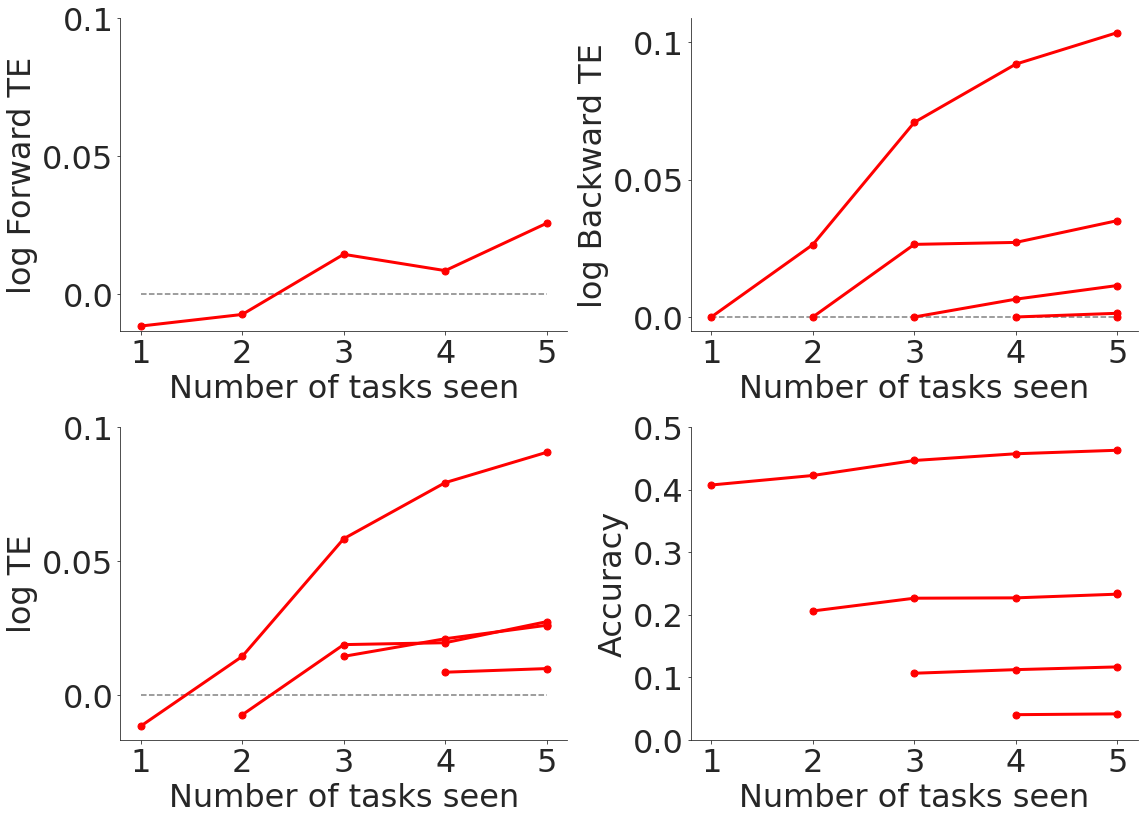

In [14]:
plot_ftebte(num_tasks, err, bte, fte, te)

## Recruitment Experiment

### Define Functions

In [5]:
class PosteriorsByTreeLearner(ClassificationProgressiveLearner):
    """
    Variation on the progressive learner class ClassificationProgressiveLearner
    to allow for return of posterior probabilities by tree.
    """

    def predict_proba(self, X, task_id, transformer_ids=None):
        """
        Calls predict_proba_tree for the decider class. Works in conjunction with
        class PosteriorsByTree.
        """
        decider = self.task_id_to_decider[task_id]
        return self.task_id_to_decider[task_id].predict_proba_tree(
            X, transformer_ids=transformer_ids
        )

In [6]:
class PosteriorsByTree(SimpleArgmaxAverage):
    """Variation on the decider class SimpleArgmaxAverage to allow for return of
    posterior probabilities by tree.
    """

    def predict_proba_tree(self, X, transformer_ids=None):
        """
        Predicts posterior probabilities by tree.
        Returns array of dimension (num_transformers*len(transformer_ids))
        containing posterior probabilities.
        """
        vote_per_alltrees = []
        for transformer_id in (
            transformer_ids
            if transformer_ids is not None
            else self.transformer_id_to_voters_.keys()
        ):
            for bag_id in range(
                len(self.transformer_id_to_transformers_[transformer_id])
            ):
                transformer = self.transformer_id_to_transformers_[transformer_id][
                    bag_id
                ]
                X_transformed = transformer.transform(X)
                voter = self.transformer_id_to_voters_[transformer_id][bag_id]
                vote = voter.predict_proba(X_transformed)
                vote_per_alltrees.append(vote)
        return vote_per_alltrees

In [7]:
def recruitment_exp(x, y,
                    num_tasks,
                    num_trees,
                    reps,
                    estimation_set,
                    train_points_per_task,
                    test_points_per_task,
                    shift=0):
    """
    Run the recruitment experiment.
    Generalized for MNIST datasets and different task numbers.
    """
    
    # shift data if indicated
    x, y = shift_data(x, y, shift)

    # create matrices for storing values
    hybrid = np.zeros(reps, dtype=float)
    building = np.zeros(reps, dtype=float)
    recruiting = np.zeros(reps, dtype=float)
    uf = np.zeros(reps, dtype=float)
    mean_accuracy_dict = {"building": [], "UF": [], "recruiting": [], "hybrid": []}
    std_accuracy_dict = {"building": [], "UF": [], "recruiting": [], "hybrid": []}

    # get y values and number labels per task
    ys_by_task = [np.unique(i) for i in y]
    num_labels_by_task = [len(ys) for ys in ys_by_task]
    
    # get samples at 1x, 10x, 50x, and 100x number labels 
    last_task_sample = num_labels_by_task[-1]*np.array([1,5,10,25])

    # get the count of the least frequent label over all tasks
    min_labelct = np.min([np.min(np.unique(each_set, return_counts=True)[1]) for each_set in y])

    # iterate over all sample sizes ns
    for ns in last_task_sample:

        # size of estimation and validation sample sets
        estimation_sample_no = int(np.ceil(estimation_set * ns))
        validation_sample_no = ns - estimation_sample_no

        # repeat `rep` times
        for rep in range(reps):
            print("doing {} samples for {} th rep".format(ns,rep))

            ####### PREP DATA ##################################

            train_x_task = []
            train_y_task = []
            test_x_task = []
            test_y_task = []

            # sample [train+test]_points_per_task from each dataset
            for dataset, label in zip(x, y):

                # get min_labelct samples from each 
                sample = []
                for unique_label in np.unique(label):
                    sample += list(np.random.choice(np.where(label==unique_label)[0], min_labelct))

                # get train/test data 
                tr_x, te_x, tr_y, te_y = train_test_split(dataset[sample], label[sample], 
                                                          test_size=test_points_per_task/(train_points_per_task+test_points_per_task))
                train_x_task.append(tr_x)
                train_y_task.append(tr_y)
                test_x_task.append(te_x)
                test_y_task.append(te_y)

            ####################################################


            # initiate lifelong learner
            l2f = PosteriorsByTreeLearner(
                default_transformer_class=TreeClassificationTransformer,
                default_transformer_kwargs={},
                default_voter_class=TreeClassificationVoter,
                default_voter_kwargs={},
                default_decider_class=PosteriorsByTree,
                default_decider_kwargs={},
            )

            # train l2f on first tasks
            for task in range(num_tasks - 1):

                cur_X = train_x_task[task]
                cur_y = train_y_task[task]

                l2f.add_task(
                    cur_X,
                    cur_y,
                    num_transformers=num_trees,
                    transformer_kwargs={"kwargs":{"max_depth": 30}},
                    voter_kwargs={"classes": np.unique(cur_y)},
                    decider_kwargs={"classes": np.unique(cur_y)},
                )

            # train l2f on last task
            cur_X = train_x_task[num_tasks - 1][:estimation_sample_no]
            cur_y = train_y_task[num_tasks - 1][:estimation_sample_no]

            l2f.add_task(
                cur_X,
                cur_y,
                num_transformers=num_trees,
                transformer_kwargs={"kwargs":{"max_depth": 30}},
                voter_kwargs={"classes": np.unique(cur_y)},
                decider_kwargs={"classes": np.unique(cur_y)},
            )

            ## L2F validation ####################################
            # get posteriors for l2f on first 9 tasks
            # want posteriors_across_trees to have shape ((num_tasks-1)*num_trees, validation_sample_no, 10)
            posteriors_across_trees = l2f.predict_proba(
                train_x_task[num_tasks - 1][estimation_sample_no:],
                task_id=num_tasks - 1,
                transformer_ids=list(range(num_tasks - 1)),
            )
            # compare error in each tree and choose best num_trees/2 trees
            error_across_trees = np.zeros((num_tasks - 1) * num_trees)
            validation_target = train_y_task[num_tasks - 1][estimation_sample_no:]
            for tree in range(len(posteriors_across_trees)):
                res = np.argmax(
                    posteriors_across_trees[tree], axis=1
                ) + sum(num_labels_by_task[:num_tasks-1])
                error_across_trees[tree] = 1 - np.mean(validation_target == res)
            best_n_tree = np.argsort(error_across_trees)[:num_trees]
            best_halfn_tree = best_n_tree[:int(num_trees/2)]

            ## uf trees validation ###############################
            # get posteriors for l2f on only the 10th task
            posteriors_across_trees = l2f.predict_proba(
                train_x_task[num_tasks - 1][estimation_sample_no:],
                task_id=num_tasks - 1,
                transformer_ids=[num_tasks - 1],
            )
            # compare error in each tree and choose best num_trees/2 trees
            error_across_trees = np.zeros(num_trees)
            validation_target = train_y_task[num_tasks - 1][estimation_sample_no:]
            for tree in range(num_trees):
                res = np.argmax(
                    posteriors_across_trees[tree], axis=1
                ) + sum(num_labels_by_task[:num_tasks-1])
                error_across_trees[tree] = 1 - np.mean(validation_target == res)
            best_halfn_uf_tree = np.argsort(error_across_trees)[:int(num_trees/2)]

            ## evaluation ########################################
            # train 10th tree under each scenario: building, recruiting, hybrid, UF
            # BUILDING
            building_res = l2f.predict(
                test_x_task[num_tasks - 1], task_id=num_tasks - 1
            )
            building[rep] = 1 - np.mean(test_y_task[num_tasks - 1] == building_res)
            # UF
            uf_res = l2f.predict(
                test_x_task[num_tasks - 1],
                task_id=num_tasks - 1,
                transformer_ids=[num_tasks - 1],
            )
            uf[rep] = 1 - np.mean(test_y_task[num_tasks - 1] == uf_res)
            # RECRUITING
            posteriors_across_trees = l2f.predict_proba(
                test_x_task[num_tasks - 1],
                task_id=num_tasks - 1,
                transformer_ids=list(range(num_tasks - 1)),
            )
            recruiting_posterior = np.mean(
                np.array(posteriors_across_trees)[best_n_tree], axis=0
            )
            res = np.argmax(recruiting_posterior, axis=1) + sum(num_labels_by_task[:num_tasks-1])
            recruiting[rep] = 1 - np.mean(test_y_task[num_tasks - 1] == res)
            # HYBRID
            posteriors_across_trees_hybrid_uf = l2f.predict_proba(
                test_x_task[num_tasks - 1],
                task_id=num_tasks - 1,
                transformer_ids=[num_tasks - 1],
            )
            hybrid_posterior_all = np.concatenate(
                (
                    np.array(posteriors_across_trees)[best_halfn_tree],
                    np.array(posteriors_across_trees_hybrid_uf)[best_halfn_uf_tree],
                ),
                axis=0,
            )
            hybrid_posterior = np.mean(hybrid_posterior_all, axis=0)
            hybrid_res = np.argmax(hybrid_posterior, axis=1) + sum(num_labels_by_task[:num_tasks-1])
            hybrid[rep] = 1 - np.mean(test_y_task[num_tasks - 1] == hybrid_res)

        # print statements
        print(np.mean(building))
        print(np.mean(uf))
        print(np.mean(recruiting))
        print(np.mean(hybrid))

        # calculate mean and stdev for each
        mean_accuracy_dict["building"].append(np.mean(building))
        std_accuracy_dict["building"].append(np.std(building, ddof=1))
        mean_accuracy_dict["UF"].append(np.mean(uf))
        std_accuracy_dict["UF"].append(np.std(uf, ddof=1))
        mean_accuracy_dict["recruiting"].append(np.mean(recruiting))
        std_accuracy_dict["recruiting"].append(np.std(recruiting, ddof=1))
        mean_accuracy_dict["hybrid"].append(np.mean(hybrid))
        std_accuracy_dict["hybrid"].append(np.std(hybrid, ddof=1))
    
    return mean_accuracy_dict, std_accuracy_dict, last_task_sample

In [8]:
def recruitment_plot(mean_acc_dict, std_acc_dict, last_task_sample, num_tasks):
    """
    Plot the results from the recruitment experiment.
    """
    # determine colors and labels for figure
    colors = sns.color_palette("Set1", n_colors=len(mean_acc_dict))
    labels = ["L2F (building)", "UF (new)", "recruiting", "hybrid"]

    # plot and format figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for i, key in enumerate(mean_acc_dict):
        ax.plot(last_task_sample, mean_acc_dict[key], c=colors[i], label=labels[i])
        upper_bound = np.array(mean_acc_dict[key]) + 1.96 * np.array(std_acc_dict[key])
        lower_bound = np.array(mean_acc_dict[key]) - 1.96 * np.array(std_acc_dict[key])
        ax.fill_between(
            last_task_sample,
            upper_bound,
            lower_bound,
            where=upper_bound >= lower_bound,
            facecolor=colors[i],
            alpha=0.15,
            interpolate=False,
        )
    ax.set_title("Recruitment Across Datasets", fontsize=30)
    ax.set_ylabel("Generalization Error (Task %d)" % num_tasks, fontsize=28)
    ax.set_xlabel("Number of Task %d Samples" % num_tasks, fontsize=30)
    ax.tick_params(labelsize=28)
    ax.set_xscale("log")
    ax.set_xticks(last_task_sample)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()
    ax.set_ylim(0.8, 1.0)
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.00])
    ax.legend(fontsize=12)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    plt.tight_layout()

### Run Experiment & Plot Results

In [20]:
############################
### Main hyperparameters ###
############################
num_trees = 10
num_tasks = 5
reps = 5
estimation_set = 0.63
train_points_per_task = 1000
test_points_per_task = 100
shift = 4

doing 100 samples for 0 th rep
doing 100 samples for 1 th rep
doing 100 samples for 2 th rep
doing 100 samples for 3 th rep
doing 100 samples for 4 th rep
0.9900709219858157
0.9900709219858156
0.9858156028368794
0.9907801418439716
doing 500 samples for 0 th rep
doing 500 samples for 1 th rep
doing 500 samples for 2 th rep
doing 500 samples for 3 th rep
doing 500 samples for 4 th rep
0.9808510638297872
0.9872340425531915
0.9872340425531915
0.9872340425531915
doing 1000 samples for 0 th rep
doing 1000 samples for 1 th rep
doing 1000 samples for 2 th rep
doing 1000 samples for 3 th rep
doing 1000 samples for 4 th rep
0.975886524822695
0.9858156028368794
0.9815602836879431
0.9815602836879433
doing 2500 samples for 0 th rep
doing 2500 samples for 1 th rep
doing 2500 samples for 2 th rep
doing 2500 samples for 3 th rep
doing 2500 samples for 4 th rep
0.9680851063829788
0.9773049645390071
0.975177304964539
0.9716312056737589


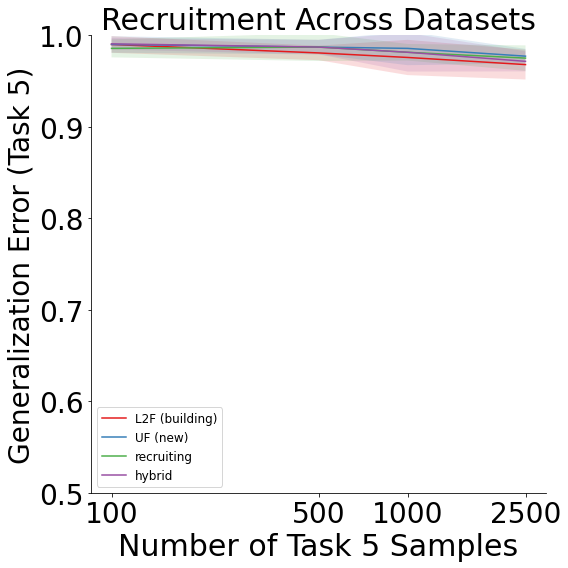

In [21]:
# run recruitment experiment
means, stds, last_task_sample = recruitment_exp(data, classes, 
                                                num_tasks,
                                                num_trees,
                                                reps,
                                                estimation_set,
                                                train_points_per_task,
                                                test_points_per_task,
                                                shift=shift)
# plot results
recruitment_plot(means, stds, last_task_sample, num_tasks)

In [22]:
# save results
np.savez_compressed("result/recruitresult_shift"+str(shift)+"_"+str(num_trees)+"trees", 
                    means=means, 
                    stds=stds)